# Medical Cost In USA

In [1]:
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
#import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# function that increases the font for the DataFrames to be readable in slides mode
def print_df(df):
    return df.style.set_properties(**{'max-width': '300px', 'font-size': '12pt'})

## Get dataset

In [3]:
df=pd.read_csv('insurance.csv')
print_df(df.head())

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.9,0,yes,southwest,16884.9
1,18,male,33.77,1,no,southeast,1725.55
2,28,male,33,3,no,southeast,4449.46
3,33,male,22.705,0,no,northwest,21984.5
4,32,male,28.88,0,no,northwest,3866.86


- **bmi**: Body Mass Index ($kg / m ^ 2$)
- **charges**: Individual medical costs billed by health insurance
- **1338 rows**

## Exploring the data

In [4]:
# define palettes for visualisation
my_pal_sex = {'male':'blue', 'female':'pink'}
my_pal_smoker = {'yes':'red', 'no':'green'}

In [ ]:
f,(ax1, ax2, ax3)= plt.subplots(1,3, sharey=True, figsize=(15,5), gridspec_kw={"width_ratios": (.25,.25,.5)})

sns.countplot(df.sex, palette = my_pal_sex, ax=ax1)
sns.countplot(df.smoker, palette = my_pal_smoker, ax=ax2)
sns.countplot(df.region, palette = "terrain", ax=ax3)
ax1.xaxis.label.set_size(16)
ax1.yaxis.label.set_size(16)
ax2.xaxis.label.set_size(16)
ax2.yaxis.label.set_size(16)
ax3.xaxis.label.set_size(16)
ax3.yaxis.label.set_size(16)
plt.show()

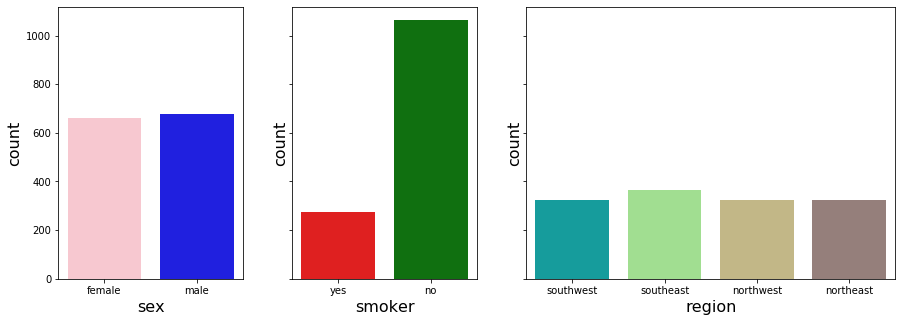

In [6]:
f

From this, it seems that the dataset sample is representative of the US population: 
* male and female equally represented
* 4 regions equally represented
* a majority of non smokers

## Exploring the data

In [7]:
print_df(round(df.describe(),1))

,age,bmi,children,charges
count,1338,1338,1338,1338
mean,39.2,30.7,1.1,13270.4
std,14,6.1,1.2,12110
min,18,16,0,1121.9
25%,27,26.3,0,4740.3
50%,39,30.4,1,9382
75%,51,34.7,2,16639.9
max,64,53.1,5,63770.4


- For age, bmi and number of children : $mean \simeq median   $ 
- For charges : $mean > median   $ 

## Exploring the data

In [ ]:
fig=plt.figure(figsize=(9,9))
grid=plt.GridSpec(13,13, wspace=0.4, hspace=0.3)


age_hist=fig.add_subplot(grid[1:6,:6])
age_box=fig.add_subplot(grid[0,:6], sharex=age_hist)


bmi_hist=fig.add_subplot(grid[1:6,7:13])
bmi_box=fig.add_subplot(grid[0,7:13], sharex=bmi_hist)


children_hist=fig.add_subplot(grid[8:13,:6])
children_box=fig.add_subplot(grid[7,:6], sharex=children_hist)


charges_hist=fig.add_subplot(grid[8:13,7:13])
charges_box=fig.add_subplot(grid[7,7:13], sharex=charges_hist)



sns.boxplot(df["age"], ax=age_box)
sns.distplot(df["age"], ax=age_hist, bins=20)
age_box.set(xlabel='')
age_hist.xaxis.label.set_size(16)

sns.boxplot(df["bmi"], ax=bmi_box)
sns.distplot(df["bmi"],ax= bmi_hist,bins=20)
bmi_box.set(xlabel='')
bmi_hist.xaxis.label.set_size(16)

sns.boxplot(df["children"], ax=children_box)
sns.distplot(df["children"],ax=children_hist, bins=6)
children_box.set(xlabel='')
children_hist.xaxis.label.set_size(16)

sns.boxplot(df["charges"],ax=charges_box)
sns.distplot(df["charges"], ax=charges_hist,bins=50)
charges_box.set(xlabel='')
charges_hist.xaxis.label.set_size(16)

plt.show()

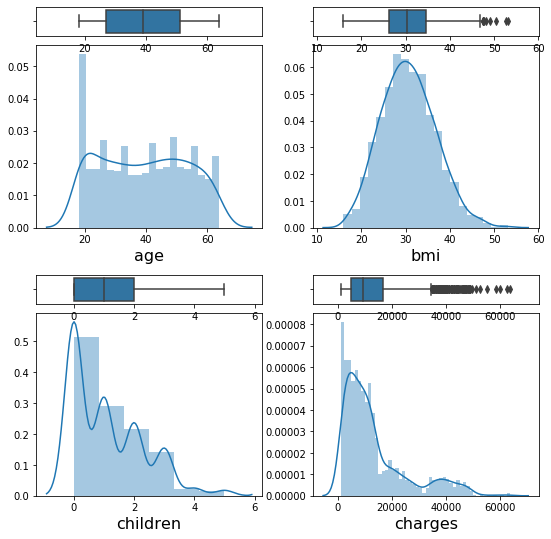

In [12]:
fig

- For charges : $mean > median   \Rightarrow$ a lot of outliers (high charges) 

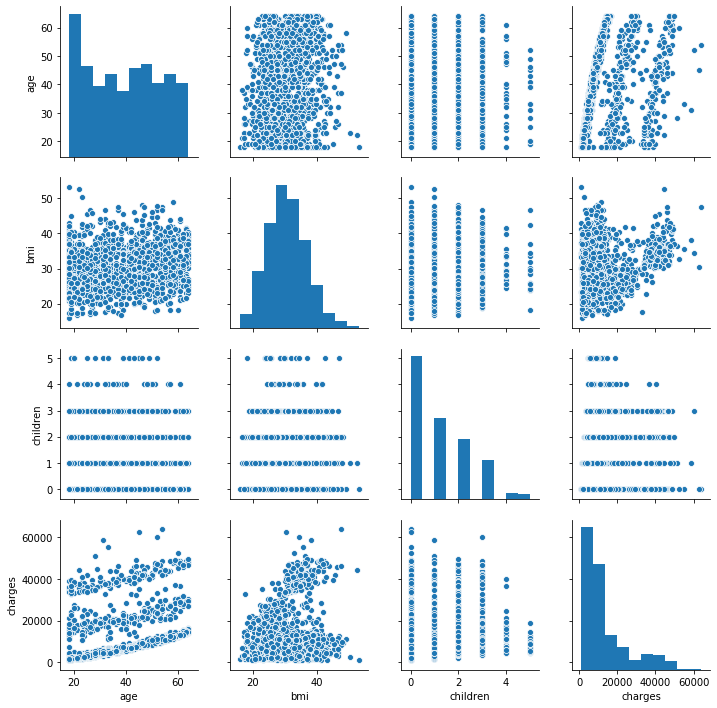

In [14]:
sns.pairplot(df)
plt.show()

### Are there any correlations between numerical columns ?

In [17]:
df.corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


In [ ]:
f2, (ax1, ax2)= plt.subplots(1,2, figsize=(15,5))

sns.heatmap(round(df.corr(),2), cmap='coolwarm', center=0, annot = True, ax=ax1)
sns.heatmap(round(df.corr(method='spearman'),2), cmap='coolwarm', center=0, annot = True, ax=ax2)

ax1.xaxis.label.set_size(16)
ax2.xaxis.label.set_size(16)
ax1.yaxis.label.set_size(16)
ax2.yaxis.label.set_size(16)

ax1.title.set_text('method = Pearson')
ax2.title.set_text('method = Spearman')

plt.show()

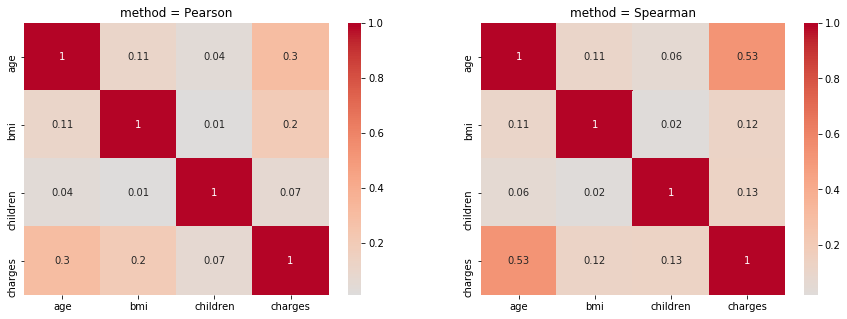

In [96]:
f2

- Charges correlated with age ?
- Charges correlated with BMI ?

In [ ]:
f3, (ax1, ax2)= plt.subplots(1,2, figsize=(15,5))

sns.scatterplot(data=df, x='bmi', y='charges',ax=ax1)
sns.scatterplot(data=df, x='age', y='charges', ax=ax2)

ax1.xaxis.label.set_size(16)
ax2.xaxis.label.set_size(16)
ax1.yaxis.label.set_size(16)
ax2.yaxis.label.set_size(16)

plt.show()

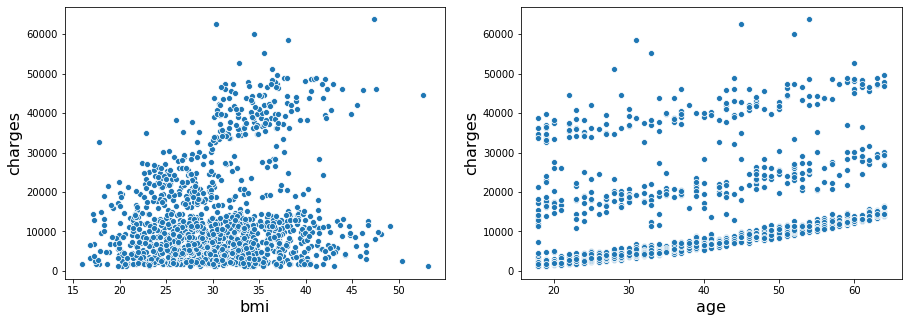

In [98]:
f3

- In the charges=f(bmi) plot, there seem to be 2 groups on points (one with low charges, one with high charges)
- In the charges=f(age) plot, there seem to be 3 groups of points forming 3 lines with a positive slope

## Scraping BMI intervals depending on gender and age

![](images/image4144.png)

In [22]:
url='https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4681110/'

In [23]:
def status_check(url):
    import requests
    r=requests.get(url)
    if r.status_code<300:
        print("request was successful")
    elif r.status_code>=400 and r.status_code<500:
        print('request failed because it is non-existant or forbidden')
    else: print('blablabla')
    return r

In [24]:
def get_soup(url):
    r=status_check(url)
    soup = BeautifulSoup(r.content)
    return soup

In [25]:
soup=get_soup(url)

request was successful


In [26]:
age_men=[i.text for i in soup.select('td:first-child')]
optimal_BMI_men=[i.text for i in soup.select('td:nth-child(2)')]
acceptable_BMI_men=[i.text for i in soup.select('td:nth-child(3)')]
age_women=[i.text for i in soup.select('td:nth-child(4)')]
optimal_BMI_women=[i.text for i in soup.select('td:nth-child(5)')]
acceptable_BMI_women=[i.text for i in soup.select('td:nth-child(6)')]

In [27]:
BMIs=pd.DataFrame([age_men, optimal_BMI_men, acceptable_BMI_men, age_women, optimal_BMI_women, acceptable_BMI_women]).T

In [28]:
BMIs.columns=['male.age', 'male.optimal', 'male.acceptable', 'female.age','female.optimal','female.acceptable']

In [29]:
BMIs

,male.age,male.optimal,male.acceptable,female.age,female.optimal,female.acceptable
0,18–34,23.0–25.9,21.0–28.9,18–34,15.5–24.9c,15.5–25.9c
1,35–44,23.0–26.9,22.0–28.9,35–44,19.0–23.9,17.5–25.9
2,45–54,24.0–27.9,23.0–28.9,45–49,20.0–25.9,19.0–26.9
3,,,,50–54,22.0–26.9,21.0–27.9
4,55–64,24.0–28.9,23.0–31.4,55–64,23.0–27.9,22.0–29.9
5,65–74,25.0–28.9,23.0–31.4,65–74,24.0–28.9,22.0–31.4
6,75–99,25.0–32.9,24.0–34.9,75–99,24.0–29.9,22.0–36.4d


### take care of missing values in men category
- for men we have one 45-54 age interval, where as for women, we have 2 intervals : 45-49 and 50-54
- we drop the men.age column, use only the women.age column as age and fill the missing values with the value in the previous row

In [30]:
#droping column male.age
BMIs=BMIs.drop(columns=['male.age'])

In [31]:
#female.age will be the common age column
BMIs=BMIs.rename(columns={'female.age':'age'})

In [32]:
#reorder the columns
BMIs=BMIs[['age', 'male.optimal', 'male.acceptable', 'female.optimal','female.acceptable']]

In [33]:
#put NaN where there is an empty string ('')
BMIs=BMIs.applymap(lambda y: np.nan if len(y)==0 else y)

In [34]:
#Then fill the NaN with the value from previous row
BMIs=BMIs.ffill(axis=0)

In [35]:
BMIs

,age,male.optimal,male.acceptable,female.optimal,female.acceptable
0,18–34,23.0–25.9,21.0–28.9,15.5–24.9c,15.5–25.9c
1,35–44,23.0–26.9,22.0–28.9,19.0–23.9,17.5–25.9
2,45–49,24.0–27.9,23.0–28.9,20.0–25.9,19.0–26.9
3,50–54,24.0–27.9,23.0–28.9,22.0–26.9,21.0–27.9
4,55–64,24.0–28.9,23.0–31.4,23.0–27.9,22.0–29.9
5,65–74,25.0–28.9,23.0–31.4,24.0–28.9,22.0–31.4
6,75–99,25.0–32.9,24.0–34.9,24.0–29.9,22.0–36.4d


### Taking care of intervals:
- transform string into list of floats [min,max]

In [36]:
BMIs=BMIs.apply(lambda x: x.str.split('–'))

In [37]:
def string_to_float(lst):
    lst2=[]
    for i in lst:
        if not i.isdigit():
            i=re.sub(r"[a-z]", "", i)
        lst2.append(float(i))
    return lst2        

In [38]:
BMIs=BMIs.applymap(lambda y: string_to_float(y))

In [39]:
print_df(BMIs)

,age,male.optimal,male.acceptable,female.optimal,female.acceptable
0,"[18.0, 34.0]","[23.0, 25.9]","[21.0, 28.9]","[15.5, 24.9]","[15.5, 25.9]"
1,"[35.0, 44.0]","[23.0, 26.9]","[22.0, 28.9]","[19.0, 23.9]","[17.5, 25.9]"
2,"[45.0, 49.0]","[24.0, 27.9]","[23.0, 28.9]","[20.0, 25.9]","[19.0, 26.9]"
3,"[50.0, 54.0]","[24.0, 27.9]","[23.0, 28.9]","[22.0, 26.9]","[21.0, 27.9]"
4,"[55.0, 64.0]","[24.0, 28.9]","[23.0, 31.4]","[23.0, 27.9]","[22.0, 29.9]"
5,"[65.0, 74.0]","[25.0, 28.9]","[23.0, 31.4]","[24.0, 28.9]","[22.0, 31.4]"
6,"[75.0, 99.0]","[25.0, 32.9]","[24.0, 34.9]","[24.0, 29.9]","[22.0, 36.4]"


In [42]:
BMIs.to_csv('BMIs.csv', index=False)

# adding a column that gives BMI range 
### (too low, optimal, acceptable,  too high)

In [43]:
def bmi_range(age,sex,bmi):
    for x,y,z in zip(BMIs['age'],BMIs[f'{sex}.optimal'], BMIs[f'{sex}.acceptable']):
        if age in pd.Interval(left=x[0], right=x[1], closed='both'):
            if bmi in pd.Interval(left=y[0], right=y[1], closed='both'):
                return 'optimal'
            elif bmi in pd.Interval(left=z[0], right=z[1], closed='both'):
                return 'acceptable'
            else:
                if bmi < z[0]:
                    return 'too low'
                else : 
                    return 'too high'

In [44]:
df['bmi_range']=df.apply(lambda row: bmi_range(row['age'], row['sex'], row['bmi']),axis=1)

In [45]:
print_df(df.sample(10))

,age,sex,bmi,children,smoker,region,charges,bmi_range
965,35,male,27.1,1,no,southwest,4746.34,acceptable
1153,35,female,35.815,1,no,northwest,5630.46,too high
426,38,female,27.265,1,no,northeast,6555.07,too high
198,51,female,18.05,0,no,northwest,9644.25,too low
1160,43,female,34.58,1,no,northwest,7727.25,too high
709,36,female,27.74,0,no,northeast,5469.01,too high
76,29,female,29.59,1,no,southeast,3947.41,too high
347,46,male,33.345,1,no,northeast,8334.46,too high
724,50,female,27.075,1,no,northeast,10106.1,acceptable
1196,19,female,30.02,0,yes,northwest,33307.6,too high


In [ ]:
fig2=sns.countplot(x='bmi_range', hue='sex', palette = my_pal_sex, data=df, 
              order=['too low', 'optimal', 'acceptable', 'too high']);
fig2.xaxis.label.set_size(16)
fig2.yaxis.label.set_size(16)

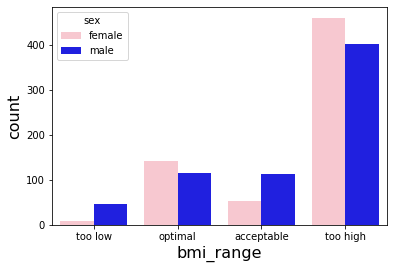

In [47]:
fig2.figure

- A majority of the people in the sample have a too high BMI!

### Influence of BMI interval

In [48]:
df2=round(df[['age', 'children', 'charges']].groupby(df.bmi_range).mean(),1)
print_df(df2.reindex(['too low', 'optimal', 'acceptable', 'too high']))

,age,children,charges
bmi_range,,,
too low,40.2,0.8,9339.1
optimal,40.3,1.1,11781.4
acceptable,37.9,1.2,11395.2
too high,39.1,1.1,14319.6


- average age approximately the same in each BMI range
- number of children : same average for bmi optimal, acceptable and too high, slightly lower for low BMI
- average charges depend on bmi range : lowest average charges for BMI too low, highest average charge for BMI too high

## Influence of gender

In [49]:
df.groupby(df.sex).mean()

,age,bmi,children,charges
sex,,,,
female,39.503021,30.377749,1.074018,12569.578844
male,38.917160,30.943129,1.115385,13956.751178


- for males and females, averages are the same exept for charges : men charged more than women ?

### Influence of smoking

In [50]:
print_df(round(df.groupby(df.smoker).mean(),1))

,age,bmi,children,charges
smoker,,,,
no,39.4,30.7,1.1,8434.3
yes,38.5,30.7,1.1,32050.2


- Smokers are charged much more: smoking has negative effect on health! 

In [ ]:
fig3, (ax1, ax2)= plt.subplots(1,2, figsize=(15,5))

sns.scatterplot(data=df, x='bmi', y='charges',hue='smoker',palette = my_pal_smoker, ax=ax1)
sns.scatterplot(data=df, x='age', y='charges',hue='smoker', palette = my_pal_smoker, ax=ax2)
ax1.xaxis.label.set_size(16)
ax1.yaxis.label.set_size(16)
ax2.xaxis.label.set_size(16)
ax2.yaxis.label.set_size(16)
plt.show()

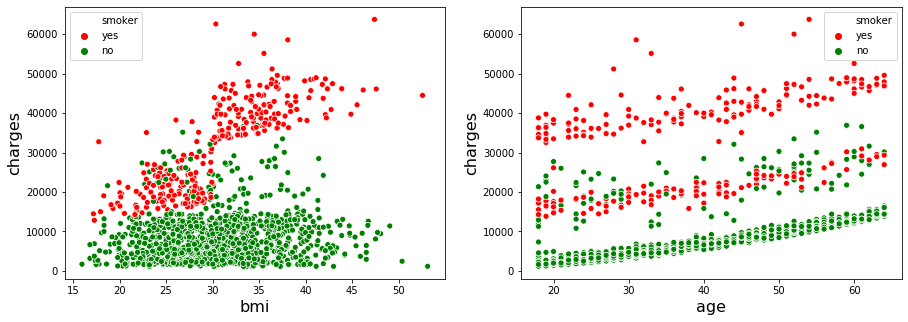

In [54]:
fig3

- In the charges=f(bmi) plot, the 2 groups on points (one with low charges, one with high charges) can be explained by smokers/non smokers
- In the charges=f(age) plot, the 3 groups of points can be _partially_ explained by smokers/non smokers

## Influence of region

In [57]:
df.groupby(df.region).mean()

,age,bmi,children,charges
region,,,,
northeast,39.268519,29.173503,1.046296,13406.384516
northwest,39.196923,29.199785,1.147692,12417.575374
southeast,38.939560,33.355989,1.049451,14735.411438
southwest,39.455385,30.596615,1.141538,12346.937377


- average age is the same in every region; number of children too
- average BMI is slightly higher in the south

## Influence of BMI range ?

In [ ]:
fig4=sns.scatterplot(data=df, x='age', y='charges', hue='bmi_range', palette="Blues_r")
fig4.xaxis.label.set_size(16)
fig4.yaxis.label.set_size(16)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.show()

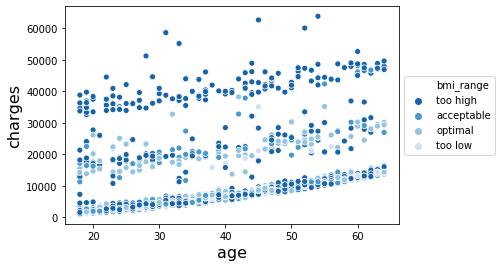

In [62]:
fig4.figure

## Influence of smoking AND BMI

In [80]:
df['smoking and bmi']=df.apply(lambda row: 'smoker and high bmi' if (row.smoker=='yes')&(row.bmi_range=='too high') else 'smoker and bmi ok' if (row.smoker=='yes')&(row.bmi_range!='too high') else 'non smoker and high bmi' if (row.smoker=='no')&(row.bmi_range=='too high') else 'non smoker and bmi ok' , axis=1)

In [81]:
my_pal_smoke_bmi={'smoker and high bmi':'red', 'smoker and bmi ok': 'orange', 'non smoker and high bmi': 'purple', 'non smoker and bmi ok': 'green'}

In [ ]:
fig5=plt.figure(figsize=(6,4.5))

axe=sns.scatterplot(data=df, x='age', y='charges',
                hue_order = ['smoker and high bmi','smoker and bmi ok','non smoker and high bmi', 'non smoker and bmi ok'], 
                hue='smoking and bmi', palette=my_pal_smoke_bmi);
fig5.set
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
axe.xaxis.label.set_size(16)
axe.yaxis.label.set_size(16)
plt.show()

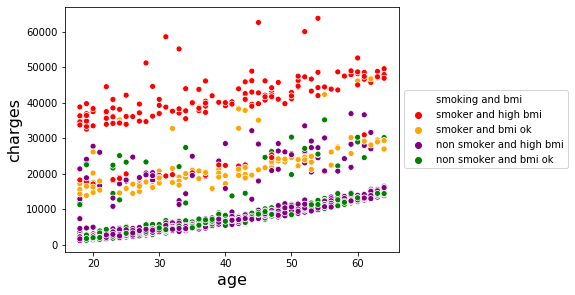

In [87]:
fig5

In the charges=f(age) plot, the 3 groups of points can be explained by:
* low charges: non smokers (independant of BMI)
* medium charges: smokers with too low, optimal or acceptable BMI
* high charges: smokers with too high BMI

## More plots

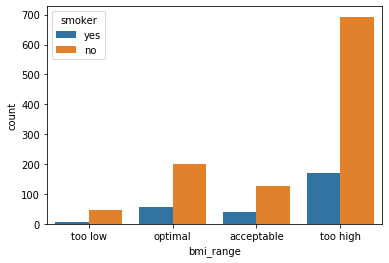

In [88]:
sns.countplot(x='bmi_range', hue='smoker', data=df, order=['too low', 'optimal', 'acceptable', 'too high']);

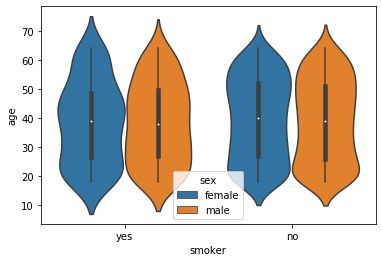

In [89]:
sns.violinplot(x='smoker', y='age', data=df, hue='sex');

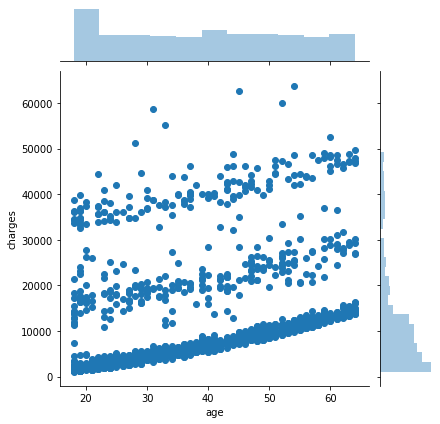

In [91]:
sns.jointplot(x='age', y='charges', data=df);

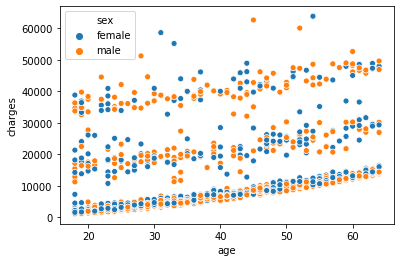

In [63]:
sns.scatterplot(data=df, x='age', y='charges', hue='sex');

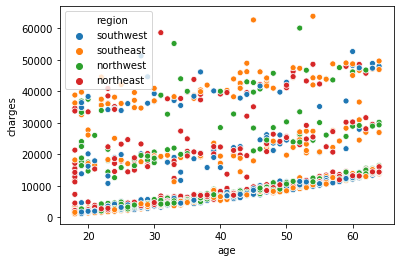

In [64]:
sns.scatterplot(data=df, x='age', y='charges', hue='region');

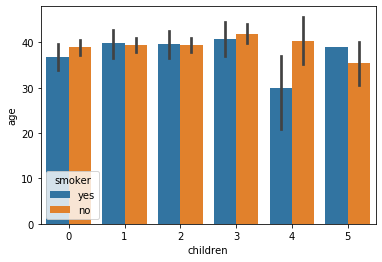

In [71]:
sns.barplot(data=df, x='children', y='age', hue='smoker');

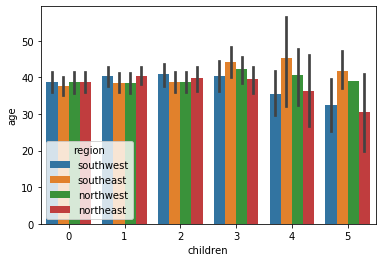

In [73]:
sns.barplot(data=df, x='children', y='age', hue='region');

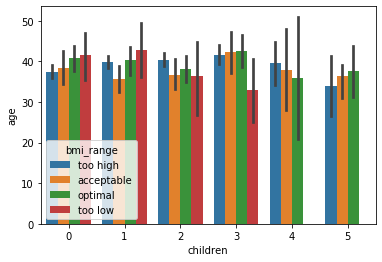

In [75]:
sns.barplot(data=df, x='children', y='age', hue='bmi_range');

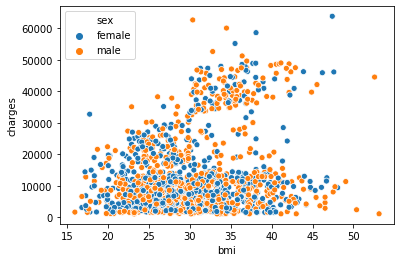

In [76]:
sns.scatterplot(data=df, x='bmi', y='charges', hue='sex');

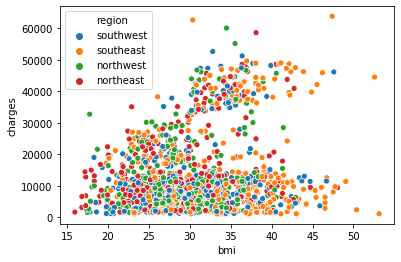

In [77]:
sns.scatterplot(data=df, x='bmi', y='charges', hue='region');